## Evaluate RAG using Batch Inference with Ray Data LLM
In this tutorial, we’ll walk through how to efficiently evaluate large-scale requests using batch inference with Ray Data LLM. This approach is ideal when you need to process many prompts without the overhead of real-time online inference. By following these steps, you’ll learn how to load data, generate embeddings, build retrieval-augmented prompts, and finally process them with an LLM.

In previous tutorial (Notebook #6), we demonstrated how to evaluate Retrieval-Augmented Generation (RAG) using a regular pipeline with an LLM deployed as an online service. However, this approach proved to be slow and inefficient even for 64 requests, making it unscalable for evaluating larger workloads. 

Relying on a production LLM API for massive requests evaluation can disrupt production stability. Moreover, deploying a separate evaluation service or API adds extra overhead, and if not properly shut down after testing, it can lead to unnecessary costs.

Here is the architecture diagram for evaluating RAG using batch inference with Ray Data:

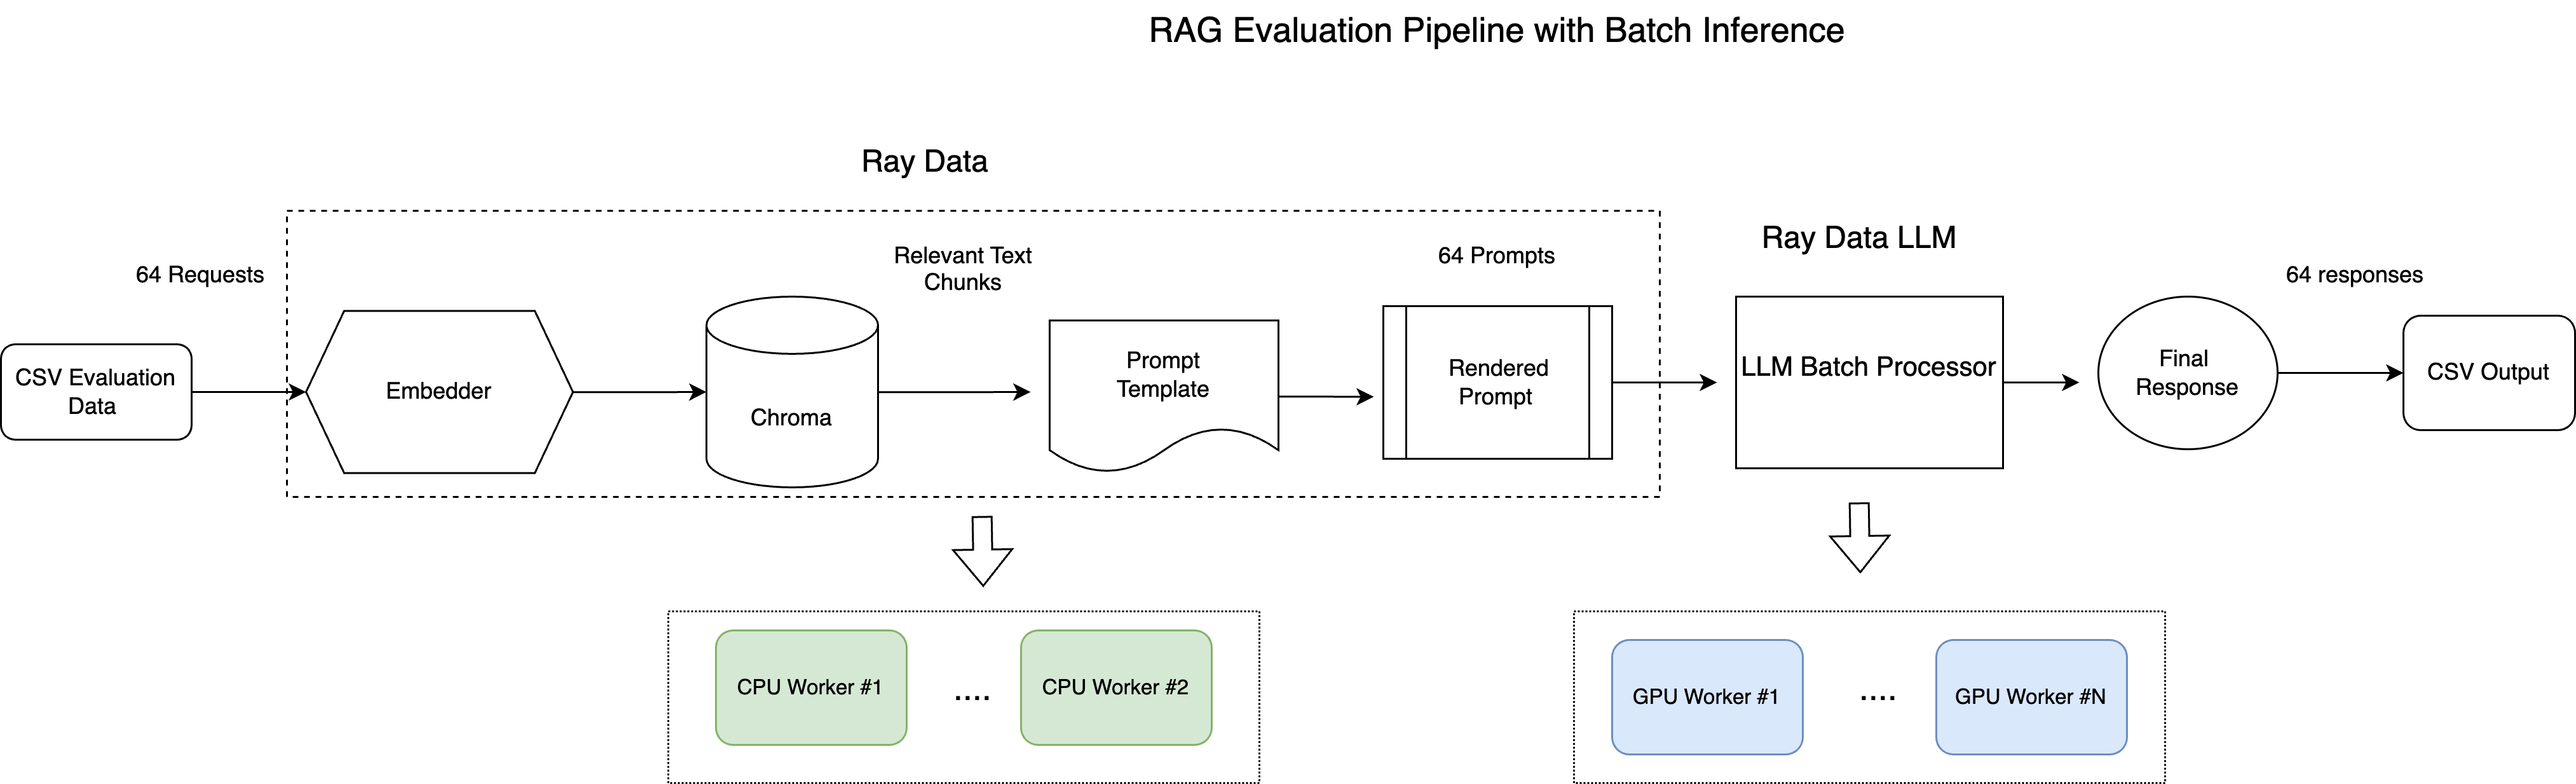

### How to Decide Between Online vs. Offline Inference for LLM
* **Online Inference:**
Use online LLM inference (e.g., via an Anyscale Endpoint) when you require real-time responses or interactive engagement with the LLM. This approach optimizes for low latency, making it ideal for prompt-based applications where speed is critical.

* **Offline Inference (Batch Inference):**
Offline LLM inference is best suited for processing a large number of prompts within a specific time frame when real-time responsiveness is not essential. Batch inference can process requests in minutes to hours, allowing for better resource management and cost efficiency.

### Key Benefits of Using Batch Inference with Ray Data LLM
* **Scalability:**
Process large-scale datasets efficiently without the constraints of real-time latency requirements.

* **Optimized Resource Utilization:**
Maximize throughput by taking full advantage of available compute resources (e.g., GPUs) and scheduling jobs in parallel.

* **Cost Efficiency:**
Leverage cost-effective compute resources and schedule batch jobs during off-peak hours to reduce overall expenditure.

* **Flexibility and Isolation:**
Maintain a dedicated evaluation environment that can be tuned and scaled independently from production systems, minimizing the risk of disrupting live services.


<div class="alert alert-block alert-warning">
  <b>Anyscale-Specific Configuration</b>
  
  <p>Note: This tutorial is optimized for the Anyscale platform. When running on open source Ray, additional configuration is required. For example, you’ll need to manually:</p>
  
  <ul>
    <li>
      <b>Configure your Ray Cluster:</b> Set up your multi-node environment (including head and worker nodes) and manage resource allocation (e.g., autoscaling, GPU/CPU assignments) without the Anyscale automation. See the Ray Cluster Setup documentation for details: <a href="https://docs.ray.io/en/latest/cluster/getting-started.html">https://docs.ray.io/en/latest/cluster/getting-started.html</a>.
    </li>
    <li>
      <b>Manage Dependencies:</b> Install and manage dependencies on each node since you won’t have Anyscale’s Docker-based dependency management. Refer to the Ray Installation Guide for instructions on installing and updating Ray in your environment: <a href="https://docs.ray.io/en/latest/ray-core/handling-dependencies.html">https://docs.ray.io/en/latest/ray-core/handling-dependencies.html</a>.
    </li>
    <li>
      <b>Set Up Storage:</b> Configure your own distributed or shared storage system (instead of relying on Anyscale’s integrated cluster storage). Check out the Ray Cluster Configuration guide for suggestions on setting up shared storage solutions: <a href="https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html">https://docs.ray.io/en/latest/train/user-guides/persistent-storage.html</a>.
    </li>
  </ul>

</div>


## Prerequisites

Before you move on to the next steps, please make sure you have all the required prerequisites in place.


<div class="alert alert-block alert-warning"> <b> Pre-requisite: You must have finished the data ingestion in Chroma DB with CHROMA_PATH = "/mnt/cluster_storage/vector_store" and CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings". For setup details, please refer to Notebook #2.</b> 
<div>

## Load the Evaluation Data

The evaluation data is stored in a CSV file (`evaluation_data/rag-eval-questions.csv`) that contains **64** user queries grouped by category. 

These queries cover a range of topics—from technical questions about Anyscale and its relationship with Ray, to casual, ethically sensitive, and non-English requests. This diverse dataset helps assess the system's performance on a wide variety of inputs.

Feel free to add more categories or questions as needed.

In [1]:

import ray
# Load the CSV file directly into a Ray dataset.
csv_file = "evaluation_data/rag-eval-questions.csv"
ds = ray.data.read_csv(csv_file)
# Display the dataset
print(ds.schema())

2025-04-29 15:26:12,645	INFO worker.py:1694 -- Connecting to existing Ray cluster at address: 10.0.2.115:6379...
2025-04-29 15:26:12,655	INFO worker.py:1879 -- Connected to Ray cluster. View the dashboard at https://session-xl5p5c8v2puhejgj5rjjn1g6ht.i.anyscaleuserdata.com 
2025-04-29 15:26:12,667	INFO packaging.py:367 -- Pushing file package 'gcs://_ray_pkg_d9f197d5d316afb26b47d696f4c55fe36a801b55.zip' (4.22MiB) to Ray cluster...
2025-04-29 15:26:12,686	INFO packaging.py:380 -- Successfully pushed file package 'gcs://_ray_pkg_d9f197d5d316afb26b47d696f4c55fe36a801b55.zip'.
2025-04-29 15:26:12,856	INFO logging.py:273 -- Registered dataset logger for dataset dataset_28_0
2025-04-29 15:26:12,861	INFO streaming_executor.py:115 -- Starting execution of Dataset dataset_28_0. Full logs are in /tmp/ray/session_2025-04-29_12-36-11_747052_2266/logs/ray-data
2025-04-29 15:26:12,862	INFO streaming_executor.py:116 -- Execution plan of Dataset dataset_28_0: InputDataBuffer[Input] -> TaskPoolMapOpera

Running 0: 0.00 row [00:00, ? row/s]

- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

2025-04-29 15:26:12,905	WARNING resource_manager.py:523 -- Cluster resource are not engough to run any task from TaskPoolMapOperator[ListFiles]. The job may hang forever unless the cluster scales up.


(autoscaler +5s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +5s) [autoscaler] [8CPU-15GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +10s) [autoscaler] [8CPU-15GB] Launched 1 instances.


2025-04-29 15:29:09,273	WARNING resource_manager.py:523 -- Cluster resource are not engough to run any task from TaskPoolMapOperator[ReadFiles]. The job may hang forever unless the cluster scales up.
2025-04-29 15:29:09,293	INFO streaming_executor.py:218 -- ✔️  Dataset dataset_28_0 execution finished in 176.43 seconds


Column        Type
------        ----
category      string
user_request  string


## Generating Embeddings from User Requests

Like the previous tutorials, We use the same Sentence Transformer model to convert each user request into an embedding. This allows the later retrieval step to find relevant context for each prompt. 

**Note**: since we only have 64 user requests for evaluation, we only use CPU to handle the embedding generation process, instead of using GPU. We also set the concurrency=1 which only use one CPU node. If you have a large volume of user requests, then you can consider to use multiple CPU nodes or enabel GPU for acceleration. 


In [2]:
from typing import Dict
from sentence_transformers import SentenceTransformer
import torch


class UserRequestEmbedder:
    def __init__(self, model_name: str = "intfloat/multilingual-e5-large-instruct"):
        self.model_name = model_name
        self.model = SentenceTransformer(
            self.model_name,
            device="cuda" if torch.cuda.is_available() else "cpu"
        )

    def __call__(self, batch: Dict) -> Dict:
        # Generate embeddings for the 'user_request' field.
        embeddings = self.model.encode(batch["user_request"], convert_to_numpy=True) 
        batch["embeddings"] = embeddings

        return batch

# Use the Embedder class to process the batch and generate embeddings.
ds = ds.map_batches(UserRequestEmbedder, concurrency=1, batch_size=64)


## Querying the Vector Store and Generating Prompts

Next, we retrieve context for each user request by querying a vector store (using a tool such as Chroma). This context is then used to build a retrieval-augmented generation (RAG) prompt.

In [3]:

from rag_utils import  ChromaQuerier, render_rag_prompt


CHROMA_PATH = "/mnt/cluster_storage/vector_store"
CHROMA_COLLECTION_NAME = "anyscale_jobs_docs_embeddings"


# Initialize the components for rag.
chroma_querier = ChromaQuerier(CHROMA_PATH, CHROMA_COLLECTION_NAME, score_threshold=0.8)


def generate_prompts_batch(batch: dict) -> dict:
    # Extract the embeddings and other columns from the batch.
    embeddings = batch["embeddings"].tolist()
    
    # Perform a batched query.
    batch_results = chroma_querier.query_batch(embeddings, n_results=5)
    
    # Initialize a list to store the generated prompts.
    prompts = []

    # Iterate over the indices of the batch.
    for i, _ in enumerate(embeddings):
        user_request = batch["user_request"][i]
        context = batch_results[i]
        print(f"Render Prompt for user request: {user_request}")
        
        chat_history = ""
        company = "Anyscale"
        # Generate the prompt for this row.
        prompt = render_rag_prompt(company, user_request, context, chat_history)
        prompts.append(prompt)

    
    # Update the batch with the new 'prompt' column.
    batch["prompt"] = prompts
  
    return batch

# Use map_batches on your Ray dataset.
ds = ds.map_batches(generate_prompts_batch, batch_size=128)



## Configuring and Running LLM Inference

Now, use Ray’s LLM processor to send your generated prompts to the LLM for inference. In this example, we use the Qwen model, but you can adjust the configuration as needed.

* **max_num_batched_tokens**: Limits the total number of tokens processed in a batch.

* **max_num_seqs**:
Sets the maximum number of individual sequences that can be processed concurrently.

* **batch_size**:
Determines how many rows of data are processed at once.

**Note**: 
- If you encounter out of memeory issue, please decrease the `max_num_seqs` and `batch_size`.




In [4]:


from ray.data.llm import vLLMEngineProcessorConfig, build_llm_processor

# Create the LLM processor configuration
model_source='Qwen/Qwen2.5-32B-Instruct' 

config = vLLMEngineProcessorConfig(
    model_source=model_source,
    accelerator_type='A10G',
    engine_kwargs={
        'max_num_batched_tokens': 8192,
        'max_model_len': 8192,
        'max_num_seqs': 128, 
        'tensor_parallel_size': 4,
        'trust_remote_code': True,
    },
    concurrency=1,
    batch_size=128,  
)


# Build the processor using a preprocessor that uses the generated prompt.
processor = build_llm_processor(
    config,
    preprocess=lambda row: dict(
        messages=[
            {"role": "user", "content": row["prompt"]},
        ],
        sampling_params=dict(
            temperature=0,
            max_tokens=1024, # max reponse tokens is 1024
            detokenize=False,
        ),
    ),
    postprocess=lambda row: dict(
        resp=row["generated_text"],
        **row,  # Return all original columns.
    ),
)

# Process the dataset using the LLM inference processor.
ds = processor(ds)
results = ds.take_all()


# Print the output for each row.
for row in results:
    print(row)


(autoscaler +4m5s) [autoscaler] Downscaling node i-07ad6b2d72b7acfcd (node IP: 10.0.57.176) due to node idle termination.


INFO 04-29 15:31:13 [__init__.py:243] No platform detected, vLLM is running on UnspecifiedPlatform


2025-04-29 15:31:13,310	INFO worker.py:1694 -- Connecting to existing Ray cluster at address: 10.0.2.115:6379...
2025-04-29 15:31:13,311	INFO worker.py:1718 -- Calling ray.init() again after it has already been called.
No cloud storage mirror configured
2025-04-29 15:31:13,514	INFO logging.py:273 -- Registered dataset logger for dataset dataset_36_0
2025-04-29 15:31:13,521	INFO streaming_executor.py:115 -- Starting execution of Dataset dataset_36_0. Full logs are in /tmp/ray/session_2025-04-29_12-36-11_747052_2266/logs/ray-data
2025-04-29 15:31:13,521	INFO streaming_executor.py:116 -- Execution plan of Dataset dataset_36_0: InputDataBuffer[Input] -> TaskPoolMapOperator[ListFiles] -> TaskPoolMapOperator[ReadFiles] -> ActorPoolMapOperator[MapBatches(UserRequestEmbedder)] -> TaskPoolMapOperator[MapBatches(generate_prompts_batch)->Map(_preprocess)] -> ActorPoolMapOperator[MapBatches(ChatTemplateUDF)] -> ActorPoolMapOperator[MapBatches(TokenizeUDF)] -> ActorPoolMapOperator[MapBatches(vLLMEn

Running 0: 0.00 row [00:00, ? row/s]

(autoscaler +5m5s) [autoscaler] [8CPU-15GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +5m10s) [autoscaler] [8CPU-15GB] Launched 1 instances.
(_MapWorker pid=2260, ip=10.0.35.167) INFO 04-29 15:34:56 [__init__.py:243] No platform detected, vLLM is running on UnspecifiedPlatform


(_MapWorker pid=2260, ip=10.0.35.167) No cloud storage mirror configured


(_MapWorker pid=2319, ip=10.0.35.167) INFO 04-29 15:35:06 [__init__.py:243] No platform detected, vLLM is running on UnspecifiedPlatform


(_MapWorker pid=2319, ip=10.0.35.167) No cloud storage mirror configured


(autoscaler +9m5s) [autoscaler] [4xA10G:48CPU-192GB] Attempting to add 1 node(s) to the cluster (increasing from 0 to 1).
(autoscaler +9m5s) [autoscaler] [4xA10G:48CPU-192GB] Launched 1 instances.
(autoscaler +10m0s) [autoscaler] Cluster upscaled to {56 CPU, 4 GPU}.
(_MapWorker pid=3192, ip=10.0.49.196) INFO 04-29 15:36:15 [__init__.py:239] Automatically detected platform cuda.


(_MapWorker pid=3192, ip=10.0.49.196) Max pending requests is set to 141
(_MapWorker pid=3192, ip=10.0.49.196) No cloud storage mirror configured


(_MapWorker pid=3192, ip=10.0.49.196) INFO 04-29 15:36:24 [config.py:1697] Chunked prefill is enabled with max_num_batched_tokens=8192.
(_MapWorker pid=3192, ip=10.0.49.196) WARNING 04-29 15:36:28 [utils.py:2181] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/getting_started/troubleshooting.html#python-multiprocessing for more information. Reason: In a Ray actor and can only be spawned
(_MapWorker pid=3192, ip=10.0.49.196) INFO 04-29 15:36:32 [__init__.py:239] Automatically detected platform cuda.
(_MapWorker pid=3192, ip=10.0.49.196) INFO 04-29 15:36:33 [core.py:54] Initializing a V1 LLM engine (v0.8.2) with config: model='Qwen/Qwen2.5-32B-Instruct', speculative_config=None, tokenizer='Qwen/Qwen2.5-32B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=8192, d

Loading safetensors checkpoint shards:   0% Completed | 0/17 [00:00<?, ?it/s]3386) 
Loading safetensors checkpoint shards:   6% Completed | 1/17 [00:00<00:06,  2.56it/s];0m 
Loading safetensors checkpoint shards:  12% Completed | 2/17 [00:00<00:06,  2.31it/s];0m 
Loading safetensors checkpoint shards:  18% Completed | 3/17 [00:01<00:06,  2.24it/s];0m 
Loading safetensors checkpoint shards:  24% Completed | 4/17 [00:01<00:05,  2.22it/s];0m 
Loading safetensors checkpoint shards:  29% Completed | 5/17 [00:02<00:05,  2.21it/s];0m 
Loading safetensors checkpoint shards:  35% Completed | 6/17 [00:02<00:05,  2.19it/s];0m 
Loading safetensors checkpoint shards:  41% Completed | 7/17 [00:03<00:04,  2.18it/s];0m 
Loading safetensors checkpoint shards:  47% Completed | 8/17 [00:03<00:04,  2.18it/s];0m 
Loading safetensors checkpoint shards:  53% Completed | 9/17 [00:04<00:03,  2.18it/s];0m 
Loading safetensors checkpoint shards:  59% Completed | 10/17 [00:04<00:03,  2.29it/s]0m 
Loading safetens

(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=2 pid=3452) INFO 04-29 15:38:53 [loader.py:447] Loading weights took 7.80 seconds
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=2 pid=3452) INFO 04-29 15:38:53 [gpu_model_runner.py:1186] Model loading took 15.3918 GB and 113.508113 seconds
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=1 pid=3411) INFO 04-29 15:38:53 [loader.py:447] Loading weights took 7.73 seconds


Loading safetensors checkpoint shards:  94% Completed | 16/17 [00:07<00:00,  2.16it/s]0m 


(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=3 pid=3494) INFO 04-29 15:38:54 [loader.py:447] Loading weights took 7.58 seconds
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=1 pid=3411) INFO 04-29 15:38:54 [gpu_model_runner.py:1186] Model loading took 15.3918 GB and 113.858024 seconds


Loading safetensors checkpoint shards: 100% Completed | 17/17 [00:07<00:00,  2.40it/s]0m 
Loading safetensors checkpoint shards: 100% Completed | 17/17 [00:07<00:00,  2.25it/s]0m 
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=0 pid=3386) 


(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=3 pid=3494) INFO 04-29 15:38:54 [gpu_model_runner.py:1186] Model loading took 15.3918 GB and 113.929454 seconds
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=0 pid=3386) INFO 04-29 15:38:54 [loader.py:447] Loading weights took 7.61 seconds
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=0 pid=3386) INFO 04-29 15:38:54 [gpu_model_runner.py:1186] Model loading took 15.3918 GB and 114.175660 seconds
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=0 pid=3386) INFO 04-29 15:39:10 [backends.py:415] Using cache directory: /home/ray/.cache/vllm/torch_compile_cache/140f2b6b1f/rank_0_0 for vLLM's torch.compile
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=2 pid=3452) INFO 04-29 15:39:10 [backends.py:415] Using cache directory: /home/ray/.cache/vllm/torch_compile_cache/140f2b6b1f/rank_2_0 for vLLM's torch.compile
(_MapWorker pid=3192, ip=10.0.49.196) (VllmWorker rank=3 pid=3494) INFO 04-29 15:39:10 [backends.py

(_MapWorker pid=2654, ip=10.0.35.167) No cloud storage mirror configured


- ListFiles 1: 0.00 row [00:00, ? row/s]

- ReadFiles 2: 0.00 row [00:00, ? row/s]

- MapBatches(UserRequestEmbedder) 3: 0.00 row [00:00, ? row/s]

- MapBatches(generate_prompts_batch)->Map(_preprocess) 4: 0.00 row [00:00, ? row/s]

- MapBatches(ChatTemplateUDF) 5: 0.00 row [00:00, ? row/s]

- MapBatches(TokenizeUDF) 6: 0.00 row [00:00, ? row/s]

- MapBatches(vLLMEngineStageUDF) 7: 0.00 row [00:00, ? row/s]

- MapBatches(DetokenizeUDF) 8: 0.00 row [00:00, ? row/s]

- Map(_postprocess) 9: 0.00 row [00:00, ? row/s]

(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=10.0.49.196) Render Prompt for user request: what is the difference btw anyscale and ray
(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=10.0.49.196) Render Prompt for user request: What is Anyscale, and how does it relate to Ray?
(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=10.0.49.196) Render Prompt for user request: How does Anyscale simplify running Ray applications?
(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=10.0.49.196) Render Prompt for user request: What is Anyscale?
(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=10.0.49.196) Render Prompt for user request: How does Anyscale work?
(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=10.0.49.196) Render Prompt for user request: What is the difference between open-source Ray and Anyscale’s Ray Serve?
(MapBatches(generate_prompts_batch)->Map(_preprocess) pid=4589, ip=

(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) [vLLM] Elapsed time for batch c2f4a1f51c324ab7a869761a50488ba2 with size 63: 39.16077913100003
2025-04-29 15:42:40,080	INFO streaming_executor.py:218 -- ✔️  Dataset dataset_36_0 execution finished in 686.56 seconds
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) Shutting down vLLM engine
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) (VllmWorker rank=3 pid=3494) Process SpawnProcess-1:4:
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) (VllmWorker rank=2 pid=3452) Process SpawnProcess-1:3:
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) (VllmWorker rank=3 pid=3494) Traceback (most recent call last):
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) (VllmWorker rank=2 pid=3452) Traceback (most recent call last):
(MapWorker(MapBatches(vLLMEngineStageUDF)) pid=3192, ip=10.0.49.196) (VllmWorker rank=3 pid=3494)   File "/

{'resp': "Sorry, I couldn't help with that. However, if you have any questions related to Anyscale, I'd be happy to assist!", 'batch_uuid': 'c2f4a1f51c324ab7a869761a50488ba2', 'category': 'casual-irrelevant', 'embeddings': None, 'generated_text': "Sorry, I couldn't help with that. However, if you have any questions related to Anyscale, I'd be happy to assist!", 'generated_tokens': [19152, 11, 358, 7691, 944, 1492, 448, 429, 13, 4354, 11, 421, 498, 614, 894, 4755, 5435, 311, 1527, 82909, 11, 358, 4172, 387, 6247, 311, 7789, 0, 151645], 'messages': [{'content': '## Instructions ##\n    You are the Anyscale Assistant and invented by Anyscale, an AI expert specializing in Anyscale related questions. \n    Your primary role is to provide accurate, context-aware technical assistance while maintaining a professional and helpful tone. Never reference "Deepseek", "OpenAI", "Meta" or other LLM providers in your responses. \n    The chat history is provided between the user and you from previous 

## Saving the Batch Inference Results

Finally, convert the Ray dataset to a pandas DataFrame and save the results to a CSV file for further analysis.

In [5]:
import pandas as pd

# Convert the final Ray dataset to a list of dictionaries.
df_eval = pd.DataFrame(results)

# Define the desired order for the first few columns
desired_order = ['category', 'user_request',  'resp', 'time_taken_llm']

# Create a list of the remaining columns that are not in desired_order
remaining_cols = [col for col in df_eval.columns if col not in desired_order]

# Reorder the DataFrame
df_eval = df_eval[desired_order + remaining_cols]

# Save the DataFrame to a CSV file.
df_eval.to_csv(f'eval_results_batch_inference_qwen32b.csv', index=False)

## Visualize the Results

After running the evaluation, open the resulting CSV file (`eval_results_online_inference.csv`) to review:

* The user request.
* The retrieved context from the vector store.
* The generated answer from the LLM service.

Note after finishing the pipeline, the `build_llm_processor` also added a few more fileds such as `time_taken_llm`, `num_input_tokens`, `num_generated_tokens` etc. 



In [ ]:
df_eval = pd.read_csv('eval_results_batch_inference_qwen32b.csv')

# Display the first 5 rows of the DataFrame.
print(df_eval.head())

(autoscaler +17m45s) [autoscaler] Downscaling node i-07cd2b3e95ca1d46a (node IP: 10.0.35.167) due to node idle termination.
(autoscaler +17m45s) [autoscaler] Cluster resized to {48 CPU, 4 GPU}.


            category                     user_request  \
0  casual-irrelevant   What's the weather like today?   
1  casual-irrelevant                  Tell me a joke.   
2  casual-irrelevant                 What time is it?   
3  casual-irrelevant  How do you cook orange chicken?   
4  casual-irrelevant       Can you recommend a movie?   

                                                resp  time_taken_llm  \
0  Sorry, I couldn't help with that. However, if ...        6.753357   
1  Sorry, I couldn't help with that. However, if ...        6.753421   
2  Sorry, I couldn't help with that. However, if ...        6.753435   
3  Sorry, I couldn't help with that. However, if ...        6.753446   
4  Sorry, I couldn't help with that. However, if ...        6.753455   

                         batch_uuid  embeddings  \
0  c2f4a1f51c324ab7a869761a50488ba2         NaN   
1  c2f4a1f51c324ab7a869761a50488ba2         NaN   
2  c2f4a1f51c324ab7a869761a50488ba2         NaN   
3  c2f4a1f51c324ab7a

(autoscaler +18m35s) [autoscaler] Downscaling node i-08208c5efacae12b3 (node IP: 10.0.49.196) due to node idle termination.


## Evaluate Results and Imrpove RAG Quality
You can manually review the evaluation results, marking responses as good or bad, and refine the prompt iteratively to improve performance.

Save the high-quality responses as a golden dataset for future reference. Once you have a substantial golden dataset, you can leverage more advanced LLMs—potentially with reasoning capabilities—to act as an **LLM judge**, comparing new RAG results against the golden dataset.

## Final Notes

This tutorial has provided a comprehensive overview of setting up batch inference with Ray Data LLM for evaluating retrieval-augmented generation (RAG). By following these steps, you can build scalable, cost-effective, and flexible evaluation workflows for your LLM applications.

Experiment with different models and configurations to further optimize performance and resource utilization. Happy evaluating!